<a href="https://colab.research.google.com/github/comojin1994/AlexNet/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Tensorflow 2.0

In [0]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 41kB/s 
     |████████████████████████████████| 3.8MB 54.7MB/s 
     |████████████████████████████████| 450kB 71.7MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


### Mount Google Drive

In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd ./gdrive/My\ Drive/Deep_learning/Paper_implementation/AlexNet
!ls

/content/gdrive/My Drive/Deep_learning/Paper_implementation/AlexNet
architecture  checkpoints  image  logs	Training.ipynb


### Load Library

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, math
from tensorflow.keras import layers, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
from datetime import datetime
from tqdm import tqdm_notebook
from glob import glob
from PIL import Image
%matplotlib inline
print(tf.__version__)

2.0.0


### Hyperparameter

In [0]:
num_epoch = 100
batch_size = 32
input_shape = (32, 32, 3)
learning_rate = 0.001
dropout_rate = 0.25
num_classes = 10
initial_epoch = 1

loss_ftn = tf.keras.losses.sparse_categorical_crossentropy
metrics = ['accuracy']
optm = tf.keras.optimizers.Adam(learning_rate)

### Model
![Architecture](https://engmrk.com/wp-content/uploads/2018/10/AlexNet_Summary_Table-1024x626.jpg)

In [0]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(96, 3, 1, 'SAME', activation='relu')(inputs)
net = layers.MaxPool2D(2)(net)
net = layers.Conv2D(256, 3, 1, 'SAME', activation='relu')(net)
net = layers.MaxPool2D(2)(net)
net = layers.Conv2D(384, 3, 1, 'SAME', activation='relu')(net)
net = layers.Conv2D(384, 3, 1, 'SAME', activation='relu')(net)
net = layers.Conv2D(256, 3, 1, 'SAME', activation='relu')(net)
net = layers.MaxPool2D(2)(net)
net = layers.Flatten()(net)
net = layers.Dense(1024)(net)
net = layers.Activation('relu')(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dense(1024)(net)
net = layers.Activation('relu')(net)
net = layers.Dense(10)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='My_AlexNet')
model.compile(optimizer=optm, loss=loss_ftn, metrics=metrics)
model.summary()

Model: "My_AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       221440    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 384)         1

### Data Load

In [0]:
(train_x, train_y), (test_x, test_y) = datasets.cifar10.load_data()
train_x.shape, train_y.shape, test_x.shape, test_y.shape

170500096/170498071 [==============================] - 2s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

### Make Generator

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    dtype=tf.float32
)
validation_datagen = ImageDataGenerator(
    rescale=1./255.,
    dtype=tf.float32
)

In [0]:
train_generator = train_datagen.flow(train_x, train_y, batch_size=batch_size)
validation_generator = validation_datagen.flow(train_x, train_y, batch_size=batch_size)

### Callbacks

In [0]:
# Tensorboard
logdir = os.path.join('logs', datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard = tf.keras.callbacks.TensorBoard(
    logdir,
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

# Learning rate scheduler
def scheduler(epoch):
  if epoch < 10: return 0.001
  else: return 0.001 * math.exp(0.1 * (10 - epoch))
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

# Checkpoints
ckptdir = 'checkpoints'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    ckptdir,
    monitor='val_accuracy',
    verbose=1,
    save_best_inly=True
)

callbacks = [tensorboard, learning_rate_scheduler, checkpoint]

### Save

In [0]:
model_path = os.path.join('architecture', 'AlexNet_Architecture.json')
with open(model_path, 'w') as f:
  f.write(model.to_json())

### Training

In [0]:
history = model.fit(
    train_generator,
    epochs=num_epoch,
    callbacks=callbacks,
    validation_data=validation_generator,
    initial_epoch=initial_epoch,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

Train for 1563 steps, validate for 1563 steps

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/100
1562/1563 [============================>.] - ETA: 0s - loss: 1.7037 - accuracy: 0.3589
Epoch 00002: saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets
1563/1563 [==============================] - 65s 42ms/step - loss: 1.7035 - accuracy: 0.3590 - val_loss: 1.5174 - val_accuracy: 0.4399

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/100
1561/1563 [============================>.] - ETA: 0s - loss: 1.5591 - accuracy: 0.4260
Epoch 00003: saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets
1563/1563 [==============================] - 65s 42ms/step - loss: 1.5591 - accuracy: 0.4259 - val_loss: 1.4003 - val_accuracy: 0.4822

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/100
1561/1563 [============================>.] - ETA: 0s - loss: 1.4654 - accurac

### Install tensorboard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-03-08 05:47:44--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.87.72.17, 52.72.182.203, 34.231.69.169, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.87.72.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  59.9MB/s    in 0.2s    

2020-03-08 05:47:44 (59.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
      .format(logdir))
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://79431cab.ngrok.io


### History

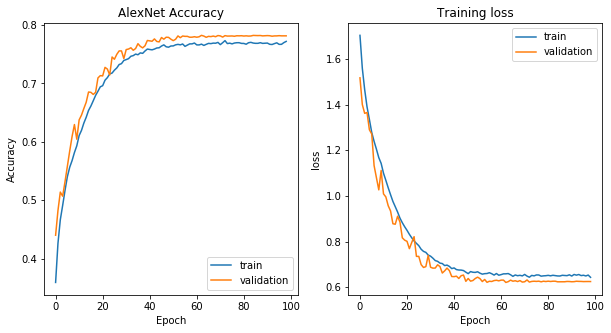

In [0]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('AlexNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

### Save Model

In [0]:
save_path = os.path.join('Model', 'AlexNet_cifar10_100epochs.h5')
model.save(save_path, include_optimizer=True)